### Optimal control of the noisy FHN model
This notebook shows how to compute the optimal control signal for the noisy FHN model for a simple example task

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. In a deterministic system, the optimal control signal should converge to the input signal. In a noisy system, this should not be possible precisely, but only approximately, depending on the noise strength.

In [8]:
# We import the model
fhn = FHNModel()
fhn.params.sigma_ou = 0.

# Some parameters to define stimulation signals
dt = fhn.params["dt"]
duration = 40.
amplitude = 1.
period = duration/4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
fhn.params["duration"] = duration
x_init = 0.
y_init = 0.
fhn.params["xs_init"] = np.array([[x_init]])
fhn.params["ys_init"] = np.array([[y_init]])

In [9]:
# define plot function for later convenience
def plot_singlenode(state, target, control, input, weight_array=[]):
    fig, ax = plt.subplots( 3,1, figsize=(8,6), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration+dt, dt)

    ax[0].plot(t_array, state[0,0,:], label="x", color=color_x)
    ax[0].plot(t_array, state[0,1,:], label="y", color=color_y)
    ax[0].plot(t_array, target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
    ax[0].plot(t_array, target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
    ax[0].legend()
    ax[0].set_title("Activity without stimulation and target activity")

    # Plot the target control signal (dashed line) and "initial" zero control signal
    ax[1].plot(t_array, control[0,0,:], label="stimulation x", color=color_x)
    ax[1].plot(t_array, control[0,1,:], label="stimulation y", color=color_y)
    ax[1].plot(t_array, input[0,0,:], linestyle='dashed', label="input x", color=color_x)
    ax[1].plot(t_array, input[0,1,:], linestyle='dashed', label="input y", color=color_y)
    ax[1].legend()
    ax[1].set_title("Active stimulation and input stimulation")

    ax[2].plot(weight_array)
    ax[2].set_title("Cost throughout optimization.")

    plt.show()

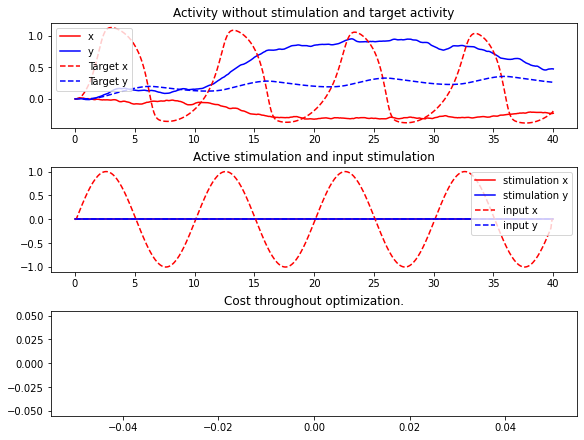

In [10]:
# We set the stimulus in x and y variables, and run the simulation in a noise-free system
fhn.params["x_ext"] = input
fhn.params["y_ext"] = zero_input
fhn.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation with noise
# Change sigma_ou_parameter to adjust the noise strength
fhn.params['sigma_ou'] = 0.1
fhn.params['tau_ou'] = 1.
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
fhn.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

plot_singlenode(state, target, control, target_input)

The target is a periodic oscillation of x and y variable (computed in deterministic, noise-free system).

The noisy, undistrubed system fluctuates around zero.

For the optimization, you can now set several new parameters:
- M: the number of noise realizations that the algorithm averages over. Default=1
- M_validation: the number of noise realization the final cost is computed from. Default=1000
- validate_per_step: If True, the cost for each step is computed averaging over M_validation instead of M realizations, this takes much longer. Default=False
- method: determines, how the noise averages are computed. Results may vary for different methods depending on the specific task. Choose from ['3']. Default='3'

Please note:
- higher number of iterations does not promise better results for computations in noisy systems. The cost will level off at some iteration number, and start increasing again afterwards. Make sure not to perform too many iterations.
- M, M_validation should increase with sigma_ou model parameter
- validate_per_step does not impact the control result

Let's optimize with the following parameters: M=20, method='3', iterations=100

Compute control for a noisy system


ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


diverging model output, decrease step size to  5.0
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  1.25
diverging model output, decrease step size to  0.625
diverging model output, decrease step size to  0.3125
Mean cost in iteration 10: 79.94147487132837
Mean cost in iteration 20: 61.16556389262774


ERROR:root:nan in model output!


diverging model output, decrease step size to  0.15625
Mean cost in iteration 30: 58.81570900805154
Mean cost in iteration 40: 48.371073217372114
Mean cost in iteration 50: 45.51746413534481
Mean cost in iteration 60: 45.307004640046394
Mean cost in iteration 70: 42.01136634201852
Mean cost in iteration 80: 37.639555767262245
Mean cost in iteration 90: 38.69671108349953
Mean cost in iteration 100: 40.51247529080931


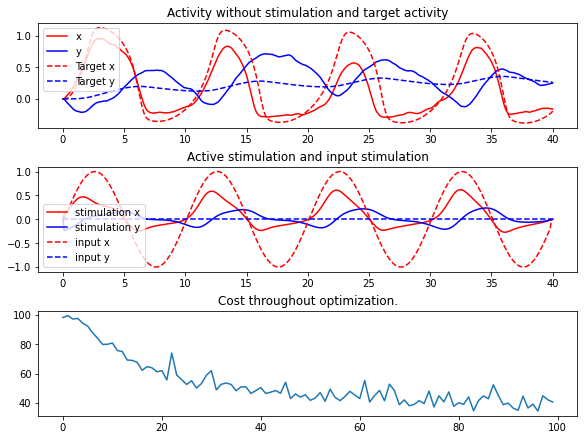

In [11]:


# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
fhn_controlled = oc_fhn.OcFhn(fhn, target, w_p=1, w_2=0, print_array=np.arange(0,101,10),
                              M=20, M_validation=500, validate_per_step=True, method='3')

# We run 100 iterations of the optimal control gradient descent algorithm
fhn_controlled.optimize(100)

state = fhn_controlled.get_xs()
control = fhn_controlled.control

plot_singlenode(state, target, control, target_input, fhn_controlled.cost_history)


Let's do the same thing with different parameters: M=100, method='3', iterations=30

Compute control for a noisy system


ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


Mean cost in iteration 1: 99.41284891966113
diverging model output, decrease step size to  5.0
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  1.25
diverging model output, decrease step size to  0.625
diverging model output, decrease step size to  0.3125
Mean cost in iteration 2: 99.27952542852839
Mean cost in iteration 3: 96.65264106786987
Mean cost in iteration 4: 95.73185779679747
Mean cost in iteration 5: 92.49026815338543
Mean cost in iteration 6: 90.71139862751215
Mean cost in iteration 7: 86.69821661311829
Mean cost in iteration 8: 83.44266473340996
Mean cost in iteration 9: 83.84683491816234


ERROR:root:nan in model output!


diverging model output, decrease step size to  0.15625
Mean cost in iteration 10: 78.33931272320353
Mean cost in iteration 11: 77.26151068002879
Mean cost in iteration 12: 71.92413470104576
Mean cost in iteration 13: 71.68425479321603
Mean cost in iteration 14: 66.39075482252505
Mean cost in iteration 15: 70.77516460846634
Mean cost in iteration 16: 63.35188360752
Mean cost in iteration 17: 65.64572738151138
Mean cost in iteration 18: 62.947827053067954
Mean cost in iteration 19: 63.25464064859096
Mean cost in iteration 20: 59.23246571431469
Mean cost in iteration 21: 63.727211006796466
Mean cost in iteration 22: 58.70421246390858
Mean cost in iteration 23: 58.90628969979576
Mean cost in iteration 24: 54.38695808036956
Mean cost in iteration 25: 57.88036807934414
Mean cost in iteration 26: 54.0413436250593
Mean cost in iteration 27: 55.77342123141343
Mean cost in iteration 28: 52.90256655349786
Mean cost in iteration 29: 55.21928321831401
Mean cost in iteration 30: 54.19591641286443


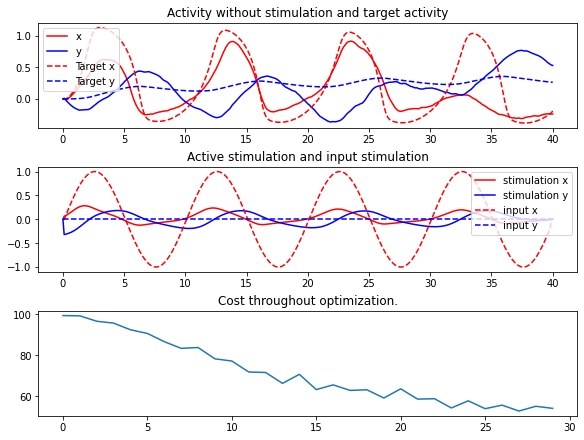

In [13]:
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
fhn_controlled = oc_fhn.OcFhn(fhn, target, w_p=1, w_2=0, print_array=np.arange(0,31,5),
                              M=100, M_validation=500, validate_per_step=True, method='3')

fhn_controlled.optimize(30)

state = fhn_controlled.get_xs()
control = fhn_controlled.control

plot_singlenode(state, target, control, target_input, fhn_controlled.cost_history)

Apparently, for this problem, the first approach is more efficient.

The larger M leads to a more steady decrease in cost in the second approach.

### Network case

In [14]:
# define plot function for later convenience
def plot_nw(state, target, control, input, weight_array=[], step_array=[]):

    t_array = np.arange(0, duration+dt, dt)
    fig, ax = plt.subplots( 3,2, figsize=(12,8), constrained_layout=True)

    for n in range(fhn.params.N):
        ax[0,n].plot(t_array, state[n,0,:], label="x", color=color_x)
        ax[0,n].plot(t_array, state[n,1,:], label="y", color=color_y)
        ax[0,n].plot(t_array, target[n,0,:], linestyle='dashed', label="Target x", color=color_x)
        ax[0,n].plot(t_array, target[n,1,:], linestyle='dashed', label="Target y", color=color_y)
        ax[0,n].legend()
        ax[0,n].set_title(f"Activity and target, node %s" % (n))

        # Plot the target control signal (dashed line) and "initial" zero control signal
        ax[1,n].plot(t_array, control[n,0,:], label="stimulation x", color=color_x)
        ax[1,n].plot(t_array, control[n,1,:], label="stimulation y", color=color_y)
        ax[1,n].plot(t_array, input[n,0,:], linestyle='dashed', label="input x", color=color_x)
        ax[1,n].plot(t_array, input[n,1,:], linestyle='dashed', label="input y", color=color_y)
        ax[1,n].legend()
        ax[1,n].set_title(f"Stimulation and input, node %s" % (n))

    ax[2,0].plot(weight_array)
    ax[2,0].set_title("Cost throughout optimization.")

    ax[2,1].plot(step_array)
    ax[2,1].set_title("Step size throughout optimization.")

    ax[2,1].set_ylim(bottom=0,top=None)

    plt.show()

Let us know study a simple 2-node network of noisy FHN oscillators. Each population in each node incorporates noise.We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

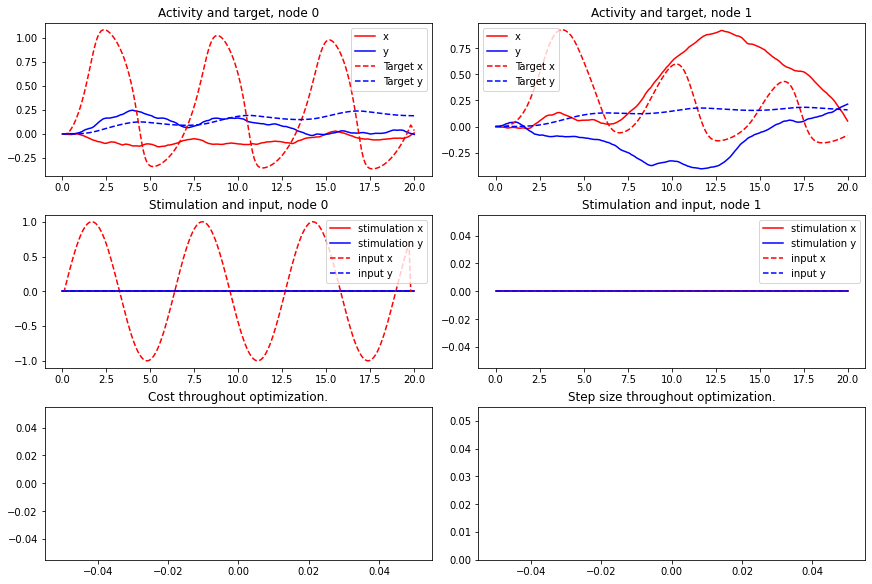

In [18]:
cmat = np.array( [[0., 0.], [1., 0.]] )  # diagonal elements are zero, connection stregth is 1 (0.) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

fhn = FHNModel(Cmat=cmat, Dmat=dmat)
fhn.params.coupling = "additive" # use additive coupling

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (fhn.params.N, len(fhn.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

if control_mat[0,0] == 0. and control_mat[1,0] == 0:
    # if x is input channel, high connection strength can lead to numerical issues
    fhn.params.K_gl = 5. # increase for stronger connectivity, WARNING: too high value will cause numerical problems

# noise free target
fhn.params['sigma_ou'] = 0.

duration = 20.

fhn.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
fhn.params["xs_init"] = np.vstack( [x_init, x_init] )
fhn.params["ys_init"] = np.vstack( [y_init, y_init] )


# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

fhn.params["x_ext"] = input_nw[:,0,:]
fhn.params["y_ext"] = input_nw[:,1,:]

fhn.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
fhn.params['sigma_ou'] = 0.1
fhn.params['tau_ou'] = 1.
fhn.params["x_ext"] = zero_input_nw[:,0,:]
fhn.params["y_ext"] = zero_input_nw[:,0,:]
fhn.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

plot_nw(state, target, zero_input_nw, input_nw)

Let's optimize with the following parameters: M=20, method='3', iterations=100

Compute control for a noisy system
Mean cost in iteration 10: 4.1181863287477904
Mean cost in iteration 20: 4.135146002747405
Mean cost in iteration 30: 3.7407463461416017
Mean cost in iteration 40: 4.144590437961794
Mean cost in iteration 50: 3.6404366975827975
Mean cost in iteration 60: 4.027548832691283
Mean cost in iteration 70: 4.223516365067279
Mean cost in iteration 80: 3.9812749307345077
Mean cost in iteration 90: 4.004308809769303
Mean cost in iteration 100: 4.108319678021478


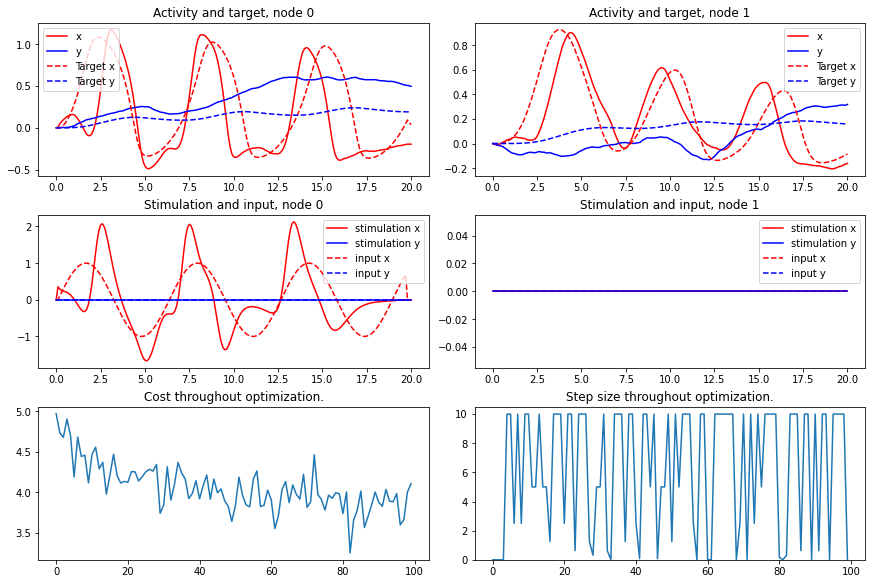

In [20]:
prec_mat = np.zeros( (fhn.params.N, len(fhn.output_vars)) )
prec_mat[1,1] = 1. # only measure in y-channel in node 1

fhn.params["x_ext"] = zero_input_nw[:,0,:]
fhn.params["y_ext"] = zero_input_nw[:,0,:]
fhn_controlled = oc_fhn.OcFhn(fhn,
                              target,
                              w_p=1,
                              w_2=0,
                              print_array=np.arange(0,101,10),
                              control_matrix=control_mat,
                              precision_matrix=prec_mat,
                              M=20,
                              M_validation=500,
                              validate_per_step=True,
                              method='3')
fhn_controlled.optimize(100)

state = fhn_controlled.get_xs()
control = fhn_controlled.control

plot_nw(state, target, control, input_nw, fhn_controlled.cost_history, fhn_controlled.step_sizes_history)

Let's do the same thing with different parameters: M=100, method='3', iterations=30

Compute control for a noisy system
Mean cost in iteration 5: 5.161155146005104
Mean cost in iteration 10: 4.7116974938319585
Mean cost in iteration 15: 4.124827687578784
Mean cost in iteration 20: 4.159162928234647
Mean cost in iteration 25: 4.047937400710729
Mean cost in iteration 30: 4.072493575303578


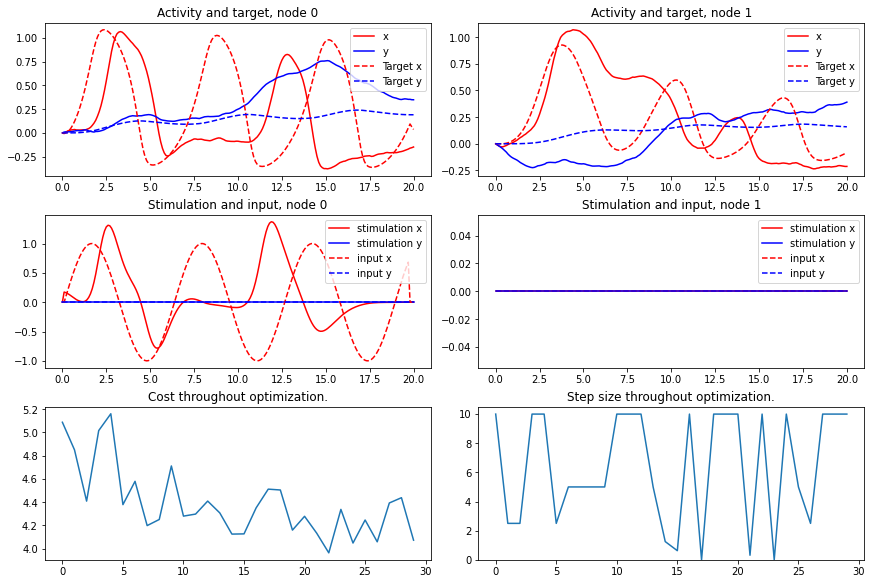

In [21]:
fhn.params["x_ext"] = zero_input_nw[:,0,:]
fhn.params["y_ext"] = zero_input_nw[:,0,:]
fhn_controlled = oc_fhn.OcFhn(fhn,
                              target,
                              w_p=1,
                              w_2=0,
                              print_array=np.arange(0,31,5),
                              control_matrix=control_mat,
                              precision_matrix=prec_mat,
                              M=100,
                              M_validation=500,
                              validate_per_step=True,
                              method='3')
fhn_controlled.optimize(30)

state = fhn_controlled.get_xs()
control = fhn_controlled.control

plot_nw(state, target, control, input_nw, fhn_controlled.cost_history, fhn_controlled.step_sizes_history)

This time, the two approaches seem similarly successful.